## 1. 固定价位止损

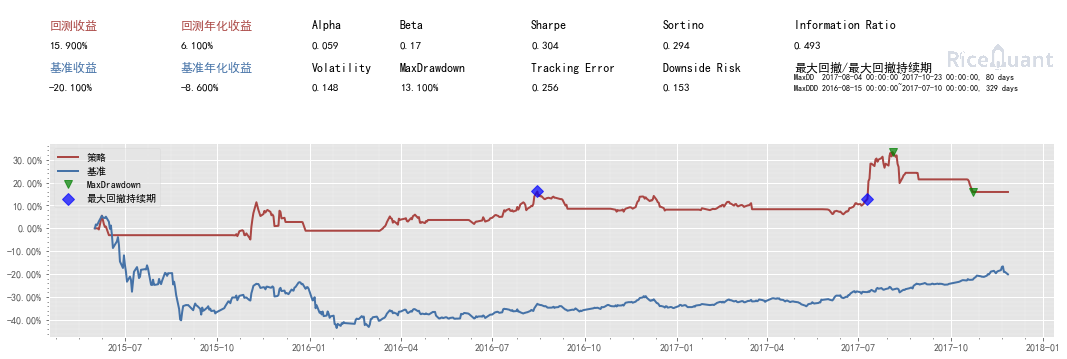

{'sys_analyser': {'benchmark_portfolio':                cash  market_value  static_unit_net_value  total_value  \
  date                                                                    
  2015-06-01  5068.72     994931.28                  1.000   1000000.00   
  2015-06-02  5068.72    1011726.52                  1.000   1016795.24   
  2015-06-03  5068.72    1008143.64                  1.017   1013212.36   
  2015-06-04  5068.72    1015558.32                  1.013   1020627.04   
  2015-06-05  5068.72    1025187.80                  1.021   1030256.52   
  2015-06-08  5068.72    1049335.00                  1.030   1054403.72   
  2015-06-09  5068.72    1042222.16                  1.054   1047290.88   
  2015-06-10  5068.72    1040585.56                  1.047   1045654.28   
  2015-06-11  5068.72    1040091.64                  1.046   1045160.36   
  2015-06-12  5068.72    1045683.52                  1.045   1050752.24   
  2015-06-15  5068.72    1023349.32                  1.051   

In [6]:
import rqalpha
from rqalpha.api import *
import talib

def init(context):
    context.s1 = "000001.XSHE"
    context.SHORTPERIOD = 10
    context.LONGPERIOD = 30
    context.stoplossmultipler= 0.98 #止损 乘数 
    context.takepofitmultipler= 3 #止盈 乘数
    
def handle_bar(context, bar_dict):
    entry_exit(context, bar_dict)
    stop_loss(context, bar_dict)
    
    
def stop_loss(context,bar_dict):
    for stock in context.portfolio.positions:
        if bar_dict[stock].last<context.portfolio.positions[stock].avg_price*context.stoplossmultipler:# 现价低于 原价一定比例
            order_target_percent(stock,0)
        elif bar_dict[stock].last>context.portfolio.positions[stock].avg_price*context.takepofitmultipler:# 现价高于原价一定比例
            order_target_percent(stock,0)

def entry_exit(context, bar_dict):
    prices = history_bars(context.s1, context.LONGPERIOD+1, '1d', 'close')
    short_avg = talib.SMA(prices, context.SHORTPERIOD)
    long_avg = talib.SMA(prices, context.LONGPERIOD)

    cur_position = context.portfolio.positions[context.s1].quantity

    if short_avg[-1] - long_avg[-1] < 0 and short_avg[-2] - long_avg[-2] > 0 and cur_position > 0:
        order_target_value(context.s1, 0)

    if short_avg[-1] - long_avg[-1] > 0 and short_avg[-2] - long_avg[-2] < 0:
        order_target_percent(context.s1, 1)

config = {
  "base": {
    "start_date": "2015-06-01",
    "end_date": "2017-12-30",
    "accounts": {'stock': 1000000},
    "benchmark": "000300.XSHG"
#     "strategy_file_path": os.path.abspath(__file__)
  },
  "extra": {
    "log_level": "error",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True
    }
  }
}

rqalpha.run_func(init=init, handle_bar=handle_bar, config=config)

## 2. 追踪止损

用字典存储股票最高价

stoploss_max = 允许最大回撤

if 现价<持股股票最高价*(1-stoploss_max):

  卖出止损

else：

  继续持有

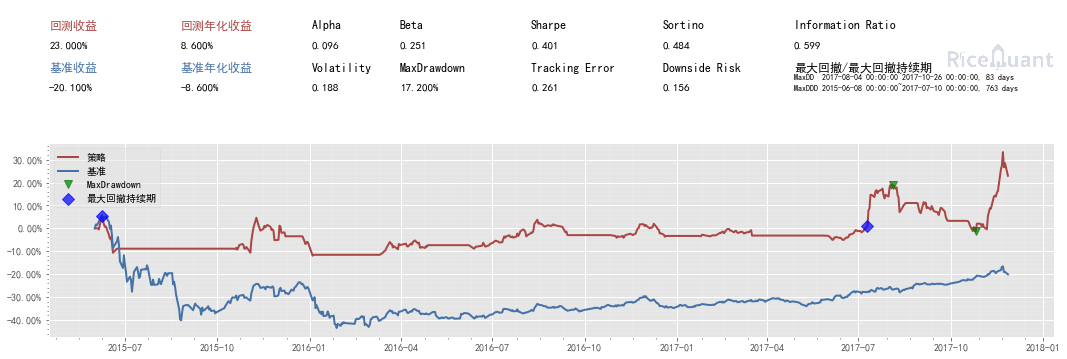

{'sys_analyser': {'benchmark_portfolio':                cash  market_value  static_unit_net_value  total_value  \
  date                                                                    
  2015-06-01  5068.72     994931.28                  1.000   1000000.00   
  2015-06-02  5068.72    1011726.52                  1.000   1016795.24   
  2015-06-03  5068.72    1008143.64                  1.017   1013212.36   
  2015-06-04  5068.72    1015558.32                  1.013   1020627.04   
  2015-06-05  5068.72    1025187.80                  1.021   1030256.52   
  2015-06-08  5068.72    1049335.00                  1.030   1054403.72   
  2015-06-09  5068.72    1042222.16                  1.054   1047290.88   
  2015-06-10  5068.72    1040585.56                  1.047   1045654.28   
  2015-06-11  5068.72    1040091.64                  1.046   1045160.36   
  2015-06-12  5068.72    1045683.52                  1.045   1050752.24   
  2015-06-15  5068.72    1023349.32                  1.051   

In [8]:
import rqalpha
from rqalpha.api import *
import talib

def init(context):
    context.s1 = "000001.XSHE"
    context.SHORTPERIOD = 10
    context.LONGPERIOD = 30
    context.stoploss_max= 0.4
    context.max = {}
    
def handle_bar(context, bar_dict):
    entry_exit(context, bar_dict)
    stop_loss(context, bar_dict)


def update_high(context, stock):
    high = history_bars(stock, 1, '1d', 'high')[0]
    try:
        Max = context.max[stock]
    except KeyError:
        Max = high
        context.max[stock] = high

    if high > Max:
        context.max[stock] = high
        return high
    else:
        return Max

def stop_loss(context,bar_dict):
    for stock in context.portfolio.positions.keys():
        high = update_high(context, stock)
        close = history_bars(stock, 1, '1d', 'close')[0]
        if close < high*(1-context.stoploss_max):
            order_target_percent(stock,0)
            context.max.pop(stock)

def entry_exit(context, bar_dict):
    prices = history_bars(context.s1, context.LONGPERIOD+1, '1d', 'close')
    short_avg = talib.SMA(prices, context.SHORTPERIOD)
    long_avg = talib.SMA(prices, context.LONGPERIOD)

    cur_position = context.portfolio.positions[context.s1].quantity

    if short_avg[-1] - long_avg[-1] < 0 and short_avg[-2] - long_avg[-2] > 0 and cur_position > 0:
        order_target_value(context.s1, 0)

    if short_avg[-1] - long_avg[-1] > 0 and short_avg[-2] - long_avg[-2] < 0:
        order_target_percent(context.s1, 1)

config = {
  "base": {
    "start_date": "2015-06-01",
    "end_date": "2017-12-30",
    "accounts": {'stock':1000000},
    "benchmark": "000300.XSHG"
#     "strategy_file_path": os.path.abspath(__file__)
  },
  "extra": {
    "log_level": "error",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True
    }
  }
}
rqalpha.run_func(init=init, handle_bar=handle_bar, config=config)

## 3. 时间止损
 
if 持股时间 >holdperiod and 周期内涨幅少于 total_return：

  卖出止损

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


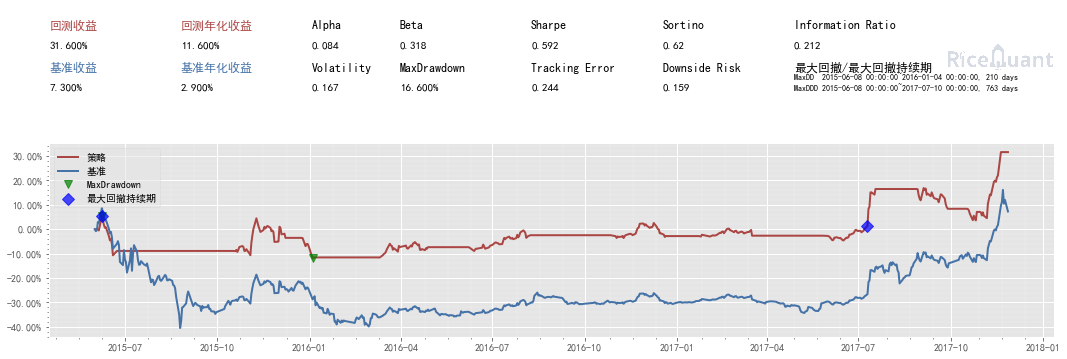

{'sys_analyser': {'benchmark_portfolio':                 cash  market_value  static_unit_net_value  total_value  \
  date                                                                     
  2015-06-01     4.900     99995.100                  1.000   100000.000   
  2015-06-02     4.900     99177.530                  1.000    99182.430   
  2015-06-03     4.900     99554.870                  0.992    99559.770   
  2015-06-04     4.900    102950.930                  0.996   102955.830   
  2015-06-05     4.900    102510.700                  1.030   102515.600   
  2015-06-08     4.900    108736.810                  1.025   108741.710   
  2015-06-09     4.900    106787.220                  1.087   106792.120   
  2015-06-10     4.900    104900.520                  1.068   104905.420   
  2015-06-11     4.900    103642.720                  1.049   103647.620   
  2015-06-12     4.900    103831.390                  1.036   103836.290   
  2015-06-15     4.900    100120.880             

In [28]:
import rqalpha
from rqalpha.api import *
import talib as ta

def init(context):
    context.to_buy = "000001.XSHE"
    context.SHORTPERIOD = 10
    context.LONGPERIOD = 30
    context.time = []
    context.holdperiod = 60
    context.total_return=0.1

def stop_loss( context,bar_dict):
    for stock in context.portfolio.positions:
        buytime=context.time # 获取买入时间
        currenttime=context.now.replace(tzinfo=None) # 获取当前时间
#         print ('buytime='+str(buytime))
#         print('currenttime='+str(currenttime))
        total_return=context.portfolio.positions[stock].market_value/(context.portfolio.positions[stock].avg_price*context.portfolio.positions[stock].quantity) # 计算回报
        hold_time=(currenttime-buytime).days # 计算持有天数
        if hold_time>context.holdperiod and total_return<1+context.total_return:
            order_target_percent(stock, 0)
        elif total_return>1+2*context.total_return:
            order_target_percent(stock, 0)
#         else:
#             print(str(stock)+ '持仓未到' +str(context.holdperiod)+'天,继续持有')

def handle_bar(context, bar_dict):
    entry_exit(context, bar_dict)
    stop_loss(context, bar_dict)

def entry_exit(context, bar_dict):
    prices = history_bars(context.to_buy, context.LONGPERIOD+1, '1d', 'close')
    short_avg = ta.SMA(prices, context.SHORTPERIOD)
    long_avg = ta.SMA(prices, context.LONGPERIOD)

    cur_position = context.portfolio.positions[context.to_buy].quantity
    shares = context.portfolio.cash/bar_dict[context.to_buy].close
    if short_avg[-1] - long_avg[-1] < 0 and short_avg[-2] - long_avg[-2] > 0 and cur_position > 0:
        order_target_value(context.to_buy, 0)

    if short_avg[-1] - long_avg[-1] > 0 and short_avg[-2] - long_avg[-2] < 0:
        order_shares(context.to_buy, shares)
        #记录买入时间
        buy_time = context.now.replace(tzinfo=None)
        context.time = buy_time

config = {
  "base": {
    "start_date": "2015-06-01",
    "end_date": "2017-12-30",
    "accounts": {'stock': 100000},
    "benchmark": "000001.XSHE"
#     "strategy_file_path": os.path.abspath(__file__)
  },
  "extra": {
    "log_level": "error",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True
    }
  }
}

rqalpha.run_func(init=init, handle_bar=handle_bar, config=config)